In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [15]:
# download ethereum data from yfinance
eth = yf.download('ETH-USD', start='2022-12-01', end='2023-12-31', interval='30m')

# convert to pandas dataframe
eth = pd.DataFrame(eth)

eth.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-11-30 22:00:00+00:00,1295.510254,1295.908325,1294.007812,1294.760498,1294.760498,46800896
2022-11-30 22:30:00+00:00,1294.801758,1295.052368,1293.837280,1294.780273,1294.780273,33482752
2022-11-30 23:00:00+00:00,1297.411255,1302.038696,1295.544067,1301.914185,1301.914185,233530368
2022-11-30 23:30:00+00:00,1301.696899,1301.696899,1295.791870,1295.791870,1295.791870,99762176
2022-12-01 00:00:00+00:00,1295.769531,1295.999878,1292.953491,1292.953491,1292.953491,95507456


<AxesSubplot:xlabel='Datetime'>

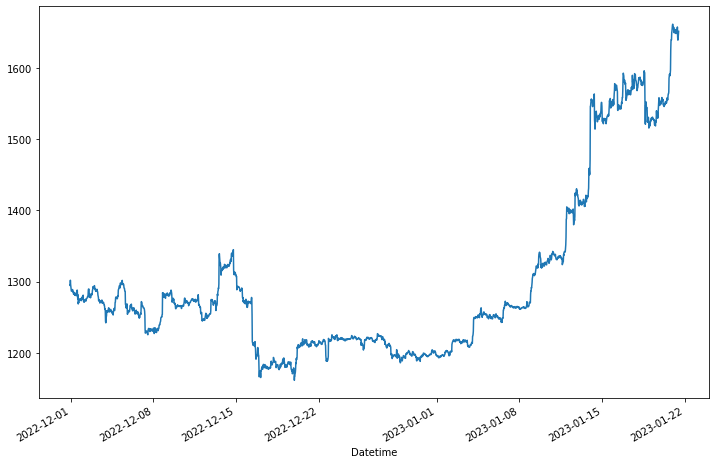

In [16]:
# only preserve the closing price
eth = eth['Close']

# plot the closing price
eth.plot(figsize=(12,8))

ADF Statistic: 1.268844
p-value: 0.996429
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


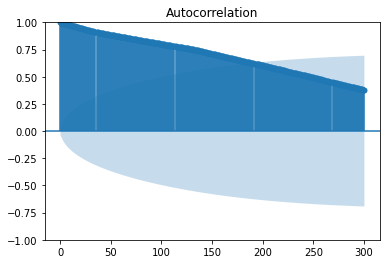

In [17]:
# adfuller test
result = adfuller(eth)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# plot autocorrelaction plot
plot_acf(eth, lags=300)
plt.show()

In [18]:
# import libraries
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
# import MAE
from sklearn.metrics import mean_absolute_error
import warnings

# split data into train and test
train_data = eth[:int(0.8*(len(eth)))]
test_data = eth[int(0.8*(len(eth))):]

# grid search for best parameters
p_values = [10]
d_values = range(1, 2)
q_values = [20, 50]

results = {}

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            warnings.filterwarnings("ignore")
            model = ARIMA(train_data, order=order).fit()
            predictions = model.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
            error = mean_absolute_error(test_data, predictions)
            print('ARIMA%s MAE=%.3f' % (order,error))
            # store the results in a dictionary results
            results[order] = error

# print the best parameters
print('Best ARIMA%s MAE=%.3f' % (min(results, key=results.get), results[min(results, key=results.get)]))

# save the best parameters
best_order = min(results, key=results.get)



ARIMA(10, 1, 20) MAE=184.372
ARIMA(10, 1, 50) MAE=184.633
Best ARIMA(10, 1, 20) MAE=184.372


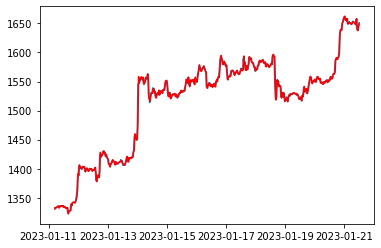

In [19]:
# plot the best model
model = ARIMA(eth, order=best_order).fit()
predictions = model.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
plt.plot(test_data)
plt.plot(predictions, color='red')
plt.show()